In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pylab as plt
plt.style.use('ggplot')
#import sncosmo
#import GPy
import subprocess
import pickle
import glob
import gzip

#import gp_sne

In [2]:
flux_norm = 1.0
time_norm = 1.0
position_norm = 1.0
grouping = 1

def SNPhotCC_Parser(filename):
    '''
    Reads and returns supernovae data into format to be read by the neural network. Replaces missing observation
    data with previous non-missing observation data - steps in data are present.
    * filename is a string containing the path to the supernovae light curve data
    * survey is a string containing the survey name
    * snid is an integer containing the supernova ID
    * ra is a float containing the RA of the supernova
    * dec is a float containing the Dec of the supernova
    * mwebv is a float describing the dust extinction
    * hostid is an integer containing the host galaxy ID
    * hostz is an array of floats containing the photometric redshift of the galaxy and the error on the measurement
    * spec is an array of floats containing the redshift
    * sim_type is a string containing the supernova type
    * sim_z is a float containing the redshift of the supernova
    * obs is a sequence of arrays each element containing [time since first observation,fluxes in each colourband,flux errors in each colourband]
    '''
    survey = snid = ra = dec = mwebv = hostid = hostz = spec = sim_type = sim_z = None
    #obs = []
    #g = r = i = z = 0
    #g_error = r_error = i_error = z_error = 0
    with gzip.open(filename, 'rb') as f:
        #first_obs = None
        for lineno,line in enumerate(f):
            s = line.split(':')
            if len(s) > 0:
                if s[0] == 'SURVEY':
                    survey = s[1].strip()
                elif s[0] == 'SNID':
                    snid = int(s[1].strip())
                elif s[0] == 'SNTYPE':
                    sn_type = int(s[1].strip())
                elif s[0] == 'RA':
                    ra = float(s[1].split('deg')[0].strip())/position_norm
                elif s[0] == 'DECL':
                    decl = float(s[1].split('deg')[0].strip())/position_norm
                elif s[0] == 'MWEBV':
                    mwebv = float(s[1].split('MW')[0].strip())
                elif s[0] == 'HOST_GALAXY_GALID':
                    hostid = int(s[1].strip())
                elif s[0] == 'HOST_GALAXY_PHOTO-Z':
                    hostz = float(s[1].split('+-')[0].strip()), float(s[1].split('+-')[1].strip())
                elif s[0] == 'REDSHIFT_SPEC':
                    spec = float(s[1].split('+-')[0].strip()), float(s[1].split('+-')[1].strip())
                elif s[0] == 'SIM_COMMENT':
                    sim_type = s[1].split('SN Type =')[1].split(',')[0].strip()
                elif s[0] == 'SIM_REDSHIFT':
                    sim_z = float(s[1])
                elif s[0] == 'VARLIST':
                    break
    obs = pd.read_table(gzip.GzipFile(filename), sep='\s+', header=0, skiprows=lineno, skipfooter=1, 
                        comment='DETECTION', engine='python',
                        usecols=[1,2,4,5,6,7,8,9])
    #obs = obs[obs.MAG < 99.]
    return survey, snid, sn_type, sim_type, sim_z, ra, decl, mwebv, hostid, hostz, spec, obs

## Example

In [3]:
N = 300
for n,f in enumerate(sorted(glob.glob('SIMGEN_PUBLIC_DES/DES_*.DAT.gz'))[:N]):
    survey, snid, sn_type, sim_type, sim_z, ra, decl, mwebv, hostid, hostz, spec, obs = SNPhotCC_Parser(f)
    #print n, snid, sn_type, sim_type, sim_z, obs.shape
    if n == 130:  # stop at a nice big lightcurve
    #if n == 0:
        break

obs.head()

,MJD,FLT,FLUXCAL,FLUXCALERR,SNR,MAG,MAGERR,SIM_MAG
0,56207.156,g,1.262,2.280,0.55,99.0,5.0,99.0
1,56207.172,r,1.830,1.603,1.14,99.0,5.0,99.0
2,56209.191,i,1.739,2.140,0.81,99.0,5.0,99.0
3,56209.215,z,1.936,2.200,0.88,99.0,5.0,99.0
4,56215.164,g,-1.567,1.595,-0.98,99.0,5.0,99.0


In [4]:
filters = [b'g', b'r', b'i', b'z'] #, b'Y']
df = obs #sne_non1a[1].to_pandas()
for filt in filters:
    df = obs[obs.FLT == filt]
    x = df.MJD.values
    y = df.FLUXCAL.values
    dy = df.FLUXCALERR.values
    
print x
print y
print dy

[ 56209.215  56217.191  56221.227  56222.211  56228.188  56229.199
  56230.215  56231.191  56235.195  56236.207  56237.238  56238.25   56243.25
  56244.223  56245.246  56246.285  56248.25   56259.18   56267.18
  56276.191  56287.191  56289.176  56297.09   56306.043  56317.066
  56326.039  56335.043  56345.992]
[   1.936     0.2291   -0.6775   -0.8444   -3.128     8.184    -1.988
   -4.663     1.502     9.221    11.41     17.07     54.49     66.56
   78.37     97.22    114.1     141.6     119.5      81.09     71.37
   70.57     62.7      46.16     30.71     23.2      14.6      13.07  ]
[  2.2     1.816   4.013   4.835   2.843   2.929   2.921   3.018   2.937
   3.195   3.874   4.873   2.626   2.56    6.105  12.91    3.711   4.047
   3.784   3.727   4.12    4.658   2.428   2.848   4.289   2.644   3.393
   3.708]


In [5]:
## see here: http://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gp_regression.html
from sklearn.gaussian_process import GaussianProcess
gp = GaussianProcess(corr='squared_exponential', regr='linear', normalize=False,
                     theta0=1e-1, thetaL=1e-3, thetaU=3., 
                     nugget=2. * (dy / np.abs(y)) ** 2.,
                     random_start=100)

X = np.atleast_2d(x).T
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
XX = np.atleast_2d(np.linspace(x.min()-100., x.max()+100.)).T
y_pred, MSE = gp.predict(XX, eval_MSE=True)
sigma = np.sqrt(MSE)

/home/dreiss/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GaussianProcess is deprecated; GaussianProcess was deprecated in version 0.18 and will be removed in 0.20. Use the GaussianProcessRegressor instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/dreiss/miniconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function l1_cross_distances is deprecated; l1_cross_distances was deprecated in version 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


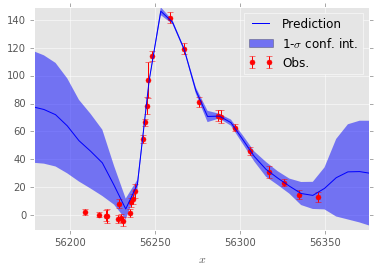

In [6]:
# Plot the function, the prediction and the 95% confidence interval based on the MSE
fig = plt.figure()
plt.errorbar(x, y, dy, fmt='r.', markersize=10, label=u'Obs.')
plt.plot(XX.ravel(), y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([XX, XX[::-1]]),
        #np.concatenate([y_pred - 1.9600 * sigma,
        #               (y_pred + 1.9600 * sigma)[::-1]]),
        np.concatenate([y_pred - sigma,
                       (y_pred + sigma)[::-1]]),
        alpha=.5, fc='b', ec='None', label='1-$\sigma$ conf. int.')
plt.xlabel('$x$')
#plt.ylabel('$f(x)$')
plt.ylim((y-dy*2.).min(), (y+dy*2.).max())
plt.xlim(x.min()-30, x.max()+30)
plt.legend(loc='upper right')

Try GPy instead. Try the devel branch:
```
pip install --user git+git://github.com/SheffieldML/GPy.git@devel
```

First, just emulate [this notebook](http://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/heteroscedastic_regression.ipynb).

 /home/dreiss/miniconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:2790: MatplotlibDeprecationWarning:Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.


 /home/dreiss/miniconda2/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


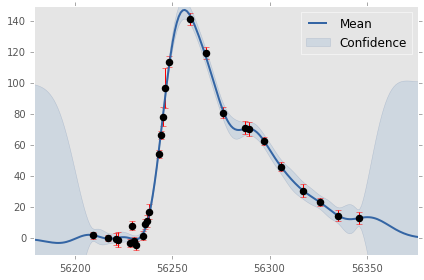

In [7]:
import GPy

#kern = GPy.kern.MLP(1) + GPy.kern.Bias(1)
#kern = GPy.kern.Linear(input_dim=1, variances=np.median(dy))
kern = GPy.kern.RBF(input_dim=1, variance=np.median(dy) * 2., lengthscale=1.)
#kern = GPy.kern.Exponential(input_dim=1, variance=np.median(dy), lengthscale=1.)

m = GPy.models.GPHeteroscedasticRegression(np.array([x]).T, np.array([y]).T, kern)
m['.*het_Gauss.variance'] = np.array([np.abs(dy) * 2.]).T # Set the noise parameters to the error in Y
m.het_Gauss.variance.fix() # We can fix the noise term, since we already know it
#m.constrain_positive()
m.optimize()

#dy[16] *= 10.; dy[17] *= 10.
m.plot_f() # Show the predictive values of the GP.
plt.errorbar(x, y, yerr=dy, fmt=None, ecolor='r', zorder=1)
plt.ylim((y-dy*2.).min(), (y+dy*2.).max())
plt.xlim(x.min()-30, x.max()+30)
plt.grid()
plt.plot(x, y, 'ko', mew=1.5)

In [8]:
newX = np.linspace(x.min(), x.max(), 28)
print newX.shape
#Y_meta = {'output_index': np.arange(len(newX))[:,None]}
#?m.predict_quantiles
#yfit = m.predict(newX)
#m.predict(newX, Y_metadata=Y_meta)
mu, var = m._raw_predict(m.X)
#m.posterior_samples(newX[:,None])

(28,)


GPy doesn't want to work, so try the example from here with scikit-learn's GPRegressor:
    
http://dan.iel.fm/george/dev/tutorials/scaling/

Try example from [here](http://dan.iel.fm/george/dev/tutorials/scaling/). First need to install dev (0.18.0) version of scikit-learn via 
```
pip install --user git+git://github.com/scikit-learn/scikit-learn.git@0.18.X
```

Now try example from [here](http://scikit-learn.org/dev/auto_examples/gaussian_process/plot_gpr_noisy_targets.html).

Also see [examples](http://scikit-learn.org/stable/auto_examples/index.html#gaussian-process-for-machine-learning) and 
[documentation](http://scikit-learn.org/dev/modules/gaussian_process.html#gp-kernels) and also 
[this documentation](http://scikit-learn.org/dev/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html)   

Also see [this good example](http://scikit-learn.org/dev/auto_examples/gaussian_process/plot_gpr_noisy.html)!

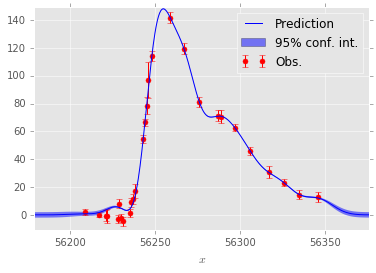

In [9]:
## see here: http://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gp_regression.html
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
#kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
kernel = RBF(10., (1e-8, 1e6)) #+ WhiteKernel(noise_level=dy)
gp = GaussianProcessRegressor(kernel=kernel, alpha=1.*(dy / np.abs(y)) ** 2.,
                              #optimizer=None, 
                              n_restarts_optimizer=10)

X = np.atleast_2d(x).T
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
XX = np.atleast_2d(np.linspace(x.min()-100., x.max()+100., 1000)).T
y_pred, sigma = gp.predict(XX, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on the MSE
fig = plt.figure()
plt.errorbar(x, y, dy, fmt='r.', markersize=10, label=u'Obs.')
plt.plot(XX.ravel(), y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([XX, XX[::-1]]),
        np.concatenate([y_pred - 1.9600 * sigma,
                       (y_pred + 1.9600 * sigma)[::-1]]),
        alpha=.5, fc='b', ec='None', label='95% conf. int.')
plt.xlabel('$x$')
#plt.ylabel('$f(x)$')
plt.ylim((y-dy*2.).min(), (y+dy*2.).max())
plt.xlim(x.min()-30, x.max()+30)
plt.legend(loc='upper right')

In [10]:
gp.kernel_

RBF(length_scale=8.68)

Finally, try [george](). First, install `eigen3` via `macports`, and also `cython`, and then install the 1.0-dev branch:
```
pip install --user git+git://github.com/dfm/george.git@1.0-dev
```
[Here are the dev version docs](http://dan.iel.fm/george/dev/user/quickstart/) - from Bryce.

Initial ln-likelihood: -118.24


(56179.214999999997, 56375.991999999998)

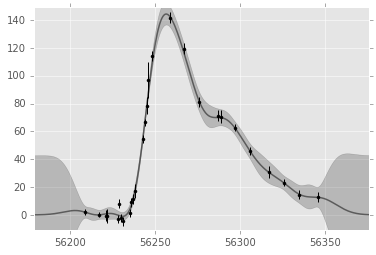

In [11]:
import george
from george import kernels

kernel = np.var(y) * kernels.ExpSquaredKernel(100)
gp = george.GP(kernel)
gp.compute(x, dy*2.)

x_pred = np.linspace(x.min()-100., x.max()+100., 1000)
pred, pred_var = gp.predict(y, x_pred, return_var=True)
print("Initial ln-likelihood: {0:.2f}".format(gp.lnlikelihood(y)))

plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
plt.errorbar(x, y, yerr=dy, fmt=".k", capsize=0)
plt.ylim((y-dy*2.).min(), (y+dy*2.).max())
plt.xlim(x.min()-30, x.max()+30)

In [12]:
from scipy.optimize import minimize

def neg_ln_like(p):
    gp.set_vector(p)
    return -gp.lnlikelihood(y)

def grad_neg_ln_like(p):
    gp.set_vector(p)
    return -gp.grad_lnlikelihood(y)

result = minimize(neg_ln_like, gp.get_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_vector(result.x)
print gp.get_parameter_names(), gp.get_vector()
print("\nFinal ln-likelihood: {0:.2f}".format(gp.lnlikelihood(y)))

      fun: 114.40768513228426
 hess_inv: array([[ 0.24733421,  0.05718299],
       [ 0.05718299,  0.07217514]])
      jac: array([  3.83355125e-09,   7.00015459e-08])
  message: 'Optimization terminated successfully.'
     nfev: 9
      nit: 7
     njev: 9
   status: 0
  success: True
        x: array([ 8.01224268,  5.39895104])
['kernel:k1:ln_constant', 'kernel:k2:ln_M_0_0'] [ 8.01224268  5.39895104]

Final ln-likelihood: -114.41


(56179.214999999997, 56375.991999999998)

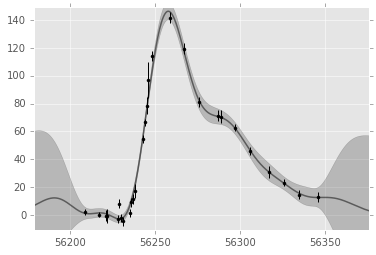

In [13]:
pred, pred_cov = gp.predict(y, x_pred, return_cov=True)
pred, pred_var = gp.predict(y, x_pred, return_var=True)

plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var), color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
plt.errorbar(x, y, yerr=dy, fmt=".k", capsize=0)
plt.ylim((y-dy*2.).min(), (y+dy*2.).max())
plt.xlim(x.min()-30, x.max()+30)

In [14]:
print pred_cov.shape
tgp, fgp, sgp = x_pred, pred, pred_cov

(1000, 1000)


### Multiple realizations from MVN random generator

(30, 1000)


 /home/dreiss/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning:covariance is not positive-semidefinite.


(56179.214999999997, 56375.991999999998)

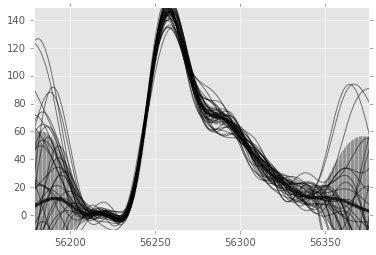

In [15]:
realizations = np.random.multivariate_normal(fgp, sgp, size=30)
print realizations.shape

plt.errorbar(tgp, fgp, yerr=np.sqrt(sgp.diagonal()), fmt=".k", capsize=0, alpha=0.2)
for i in range(30):
    plt.plot(tgp, realizations[i], "k", alpha=0.5)
plt.ylim((y-dy*2.).min(), (y+dy*2.).max())
plt.xlim(x.min()-30, x.max()+30)

### Multiple realizations from the posterior

(30, 1000)


 /home/dreiss/miniconda2/lib/python2.7/site-packages/george/utils.py:30: RuntimeWarning:covariance is not positive-semidefinite.


(56179.214999999997, 56375.991999999998)

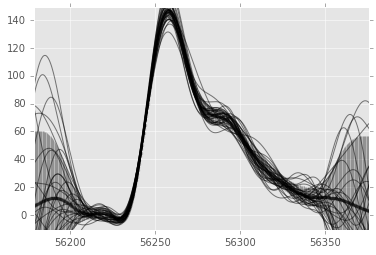

In [16]:
samples = gp.sample_conditional(y, x_pred, size=30)
print samples.shape

plt.errorbar(tgp, fgp, yerr=np.sqrt(sgp.diagonal()), fmt=".k", capsize=0, alpha=0.2)
for i in range(30):
    plt.plot(tgp, samples[i], "k", alpha=0.5)
plt.ylim((y-dy*2.).min(), (y+dy*2.).max())
plt.xlim(x.min()-30, x.max()+30)